<a href="https://colab.research.google.com/github/stepanjaburek/workingpaper_czech_psp_speeches/blob/main/Sentiment(PolDEBATE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment classification using the Poltical DEBATE model by Burnham et al. (2024)**

# Setup

In [ ]:
#!pip install scikit-learn
!pip install krippendorff
import pandas as pd
import numpy as np
import sklearn
import krippendorff
import torch
from transformers import pipeline
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

# Model specification and analysis

In [38]:
model_name = "mlburnham/Political_DEBATE_large_v1.0"
hypothesis_template =  "The emotional valence of this text towards left-wing politics, socialism, communism is {}"
classes = ["positive", "neutral", "negative"]

device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("zero-shot-classification",
                     model=model_name,
                     device=device)

In [39]:
def analyze_sentiments(df, classifier, classes, hypothesis, batch_size=16):
    results = []
    for i in tqdm(range(0, len(df), batch_size)):
        batch_output = classifier(
            df['translated_context_40'][i:i + batch_size].tolist(),
            classes,
            hypothesis_template=hypothesis,
            multi_label=False,
            batch_size=batch_size
        )

        for item in batch_output:
            results.append({
                'label': item['labels'][0],
                'score': item['scores'][0],
                **{f'{label}_score': score for label, score in zip(item['labels'], item['scores'])}
            })

    return pd.DataFrame(results)

In [40]:
#df = pd.read_csv("/content/translated_left.csv")
df = pd.read_excel('/content/Book1 (1).xlsx')
results = analyze_sentiments(df, classifier, classes, hypothesis_template)

pd.concat([df, results], axis=1).to_csv('debate_sentiment_left.csv', index=False)

print("\nSentiment Distribution:")
print(results['label'].value_counts())

  0%|          | 0/3 [00:00<?, ?it/s]


Sentiment Distribution:
label
negative    24
neutral     20
Name: count, dtype: int64


In [41]:
df = pd.read_csv("/content/debate_sentiment_left.csv")
df
sklearn.metrics.precision_score(df[['label_my']], df[['label']],average='macro')
df['agreement']= np.where(df['label_my']==df['label'], 1, 0)
df['agreement'].mean()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.75

# *Confusion Matrix*

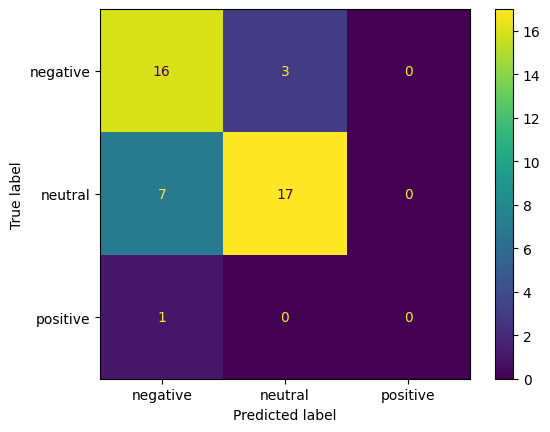

In [42]:
cm=confusion_matrix(df[['label_my']],df[['label']],labels=['negative','neutral', 'positive' ]) # True label is in the first position
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['negative','neutral', 'positive'])
disp.plot()

# *F1 Score*

In [43]:
actual = df['label_my']
predicted = df['label']

#f1_macro = f1_score(actual, predicted, average='macro')
f1_weighted = f1_score(actual, predicted, average='weighted')

#print(f"F1 Macro: {f1_macro:.3f}")
print(f"F1 Weighted: {f1_weighted:.3f}")

F1 Weighted: 0.743


# *MCC*

In [44]:
mcc = matthews_corrcoef(actual, predicted)
print(f"MCC Score: {mcc:.3f}")

MCC Score: 0.527
